In [2]:
import numpy as np
import matplotlib.pyplot as plt

# TF/Keras
import tensorflow as tf
from tensorflow import keras

# Data



In [7]:
def make_timeseries_dataset(data, target, timesteps):
    N = len(target[timesteps:])
    X = np.zeros((N, timesteps, 1), np.float32)
    Y = np.zeros((N, 1), np.float32)
    for i in range(N):
        X[i] = data[i:i+timesteps][:,np.newaxis]
        Y[i] = target[i+timesteps]
    return X, Y

def make_dataset_for_stateful(data_list, target_list, timesteps):
    N = len(data_list)
    X = []
    Y = []
    for i in range(N):
        x, y = make_timeseries_dataset(data_list[i], target_list[i], timesteps)
        X.append(x)
        Y.append(y)
    X = np.concatenate(X, axis=(1)).reshape(-1, timesteps, 1)
    Y = np.concatenate(Y, axis=(1)).reshape(-1, 1)

    return X, Y

# Model

# VAE

In [8]:

def build_encoder(input_shape, h_dim, z_dim, name="encoder"):
    inputs = keras.layers.Input(shape=input_shape)
    x = keras.layers.Dense(h_dim, activation="relu")(inputs)
    x = keras.layers.Dense(h_dim, activation="relu")(x)
    z_mean = keras.layers.Dense(z_dim, name="z_mean")(x)
    z_log_var = keras.layers.Dense(z_dim, name="z_log_var")(x)
    outputs = [z_mean, z_log_var]
    
    return keras.Model(inputs=inputs, outputs=outputs, name=name)

def build_prior(input_shape, h_dim, z_dim, name="prior"):
    inputs = keras.layers.Input(shape=input_shape)
    x = keras.layers.Dense(h_dim, activation="relu")(inputs) 
    prior_mean = keras.layers.Dense(z_dim, name="prior_mean")(x)
    prior_log_var = keras.layers.Dense(z_dim, name="prior_log_var")(x)
    outputs = [prior_mean, prior_log_var]

    return keras.Model(inputs=inputs, outputs=outputs, name=name)

def build_decoder(input_shape, h_dim, x_dim, name="decoder"):
    inputs = keras.layers.Input(shape=input_shape)
    x = keras.layers.Dense(h_dim, activation="relu")(inputs)
    x = keras.layers.Dense(h_dim, activation="relu")(x)
    x = keras.layers.Dense(x_dim)(x)
    outputs = x
    
    return keras.Model(inputs=inputs, outputs=outputs, name=name)

class Sampling(keras.layers.Layer):
    def __init__(self, name="sampling"):
        super().__init__(name=name)
    def call(self, inputs):
        z_mean, z_log_var = inputs
        batch = tf.shape(z_mean)[0]
        dim = tf.shape(z_mean)[1]
        epsilon = tf.random.normal(shape=(batch, dim))
        return z_mean + tf.exp(0.5 * z_log_var) * epsilon

# VRNN

In [9]:
class VRNNCell(keras.layers.Layer):
    def __init__(self, h_dim, z_dim):
        super().__init__()
        self.h_dim = h_dim
        self.z_dim = z_dim
        self.state_size = h_dim

    def build(self, input_shape):
        batch_size, x_dim = input_shape

        self.phi_x_layer = keras.Sequential([
            keras.layers.Input((x_dim)),
            keras.layers.Dense(self.h_dim, activation="relu"),
            keras.layers.Dense(self.h_dim, activation="relu")
        ])
        self.phi_z_layer = keras.layers.Dense(self.h_dim, activation="relu")
        self.encoder = build_encoder(input_shape=(self.h_dim+self.h_dim), h_dim=self.h_dim, z_dim=self.z_dim)
        self.prior_layer = build_prior(input_shape=(self.h_dim), h_dim=self.h_dim, z_dim=self.z_dim)
        self.decoder = build_decoder(input_shape=(self.h_dim+self.h_dim), h_dim=self.h_dim, x_dim=x_dim)

        self.rnn_cell = keras.layers.GRUCell(self.h_dim)

        self.sampling_layer = Sampling()

    def call(self, inputs, states):
        h = states[0]   # B x h_dim

        phi_x = self.phi_x_layer(inputs)    # B x h_dim
        x = keras.layers.Concatenate(axis=(1))([phi_x, h])  # B x h_dim+h_dim

        # encoder
        z_mean, z_log_var = self.encoder(x)     # B x z_dim, B x z_dim

        # prior
        prior_mean, prior_log_var = self.prior_layer(h)     # B x z_dim, B x z_dim

        # reparametrization trick
        z = self.sampling_layer([z_mean, z_log_var])    # B x z_dim

        phi_z = self.phi_z_layer(z)     # B x z_dim
        x = keras.layers.Concatenate(axis=(1))([phi_z, h])  # B x h_dim+h_dim

        #decoder
        y = self.decoder(x)   # B x z_dim

        #recurrence
        phi = keras.layers.Concatenate(axis=(1))([phi_x, phi_z])
        _, new_h = self.rnn_cell(phi, [h])    # B x h_dim

        outputs = [y, z_mean, z_log_var, prior_mean, prior_log_var]
        new_states = [new_h]    # 1 x B x h_dim
        return outputs, new_states

In [10]:
class VRNN(keras.Model):
    def __init__(self, input_shape, h_dim=100, z_dim=16, return_sequences=False, name="vrnn", *args, **kwargs):
        super().__init__(name=name, *args, **kwargs)
        self.cell = VRNNCell(h_dim=h_dim, z_dim=z_dim)
        self.axis = (1, 2) if return_sequences else (1)

        # build model
        inputs = keras.layers.Input(input_shape)
        x = keras.layers.RNN(self.cell, return_sequences=return_sequences)(inputs)
        outputs = x
        self.rnn = keras.Model(inputs=inputs, outputs=outputs)

    def call(self, inputs, training=False):
        return self.rnn(inputs)
    
    def compile(self, optimizer, loss, *args, **kwargs):
        super().compile(*args, **kwargs)

        self.optimizer = optimizer
        self.loss = loss

        # Tracker
        self.total_cost_tracker = keras.metrics.Mean(name="total_cost")
        self.loss_tracker = keras.metrics.Mean(name="loss")
        self.kl_tracker = keras.metrics.Mean(name="kl_divergence")

    @property
    def metrics(self):
        return [
            self.total_cost_tracker,
            self.loss_tracker,
            self.kl_tracker
        ]

    def train_step(self, data):
        x, y_true = data
        with tf.GradientTape() as tape:
            outputs = self.rnn(x)
            y_pred, z_mean, z_log_var, prior_mean, prior_log_var = outputs

            # loss
            loss = tf.reduce_mean(self.loss(y_true, y_pred))

            # KL-divergence
            term1 = prior_log_var - z_log_var
            term2 = (tf.exp(z_log_var) + tf.square(z_mean - prior_mean)) / (tf.exp(prior_log_var) + 1e-12)
            term3 = -1
            kl = tf.reduce_mean(tf.reduce_sum(0.5 * (term1 + term2 + term3), axis=self.axis))

            total_cost = loss + kl

        grads = tape.gradient(total_cost, self.trainable_weights)
        self.optimizer.apply_gradients(zip(grads, self.trainable_weights))

        # Update
        self.total_cost_tracker.update_state(total_cost)
        self.loss_tracker.update_state(loss)
        self.kl_tracker.update_state(kl)

        return {m.name: m.result() for m in self.metrics}

# サンプル

#  データの取得

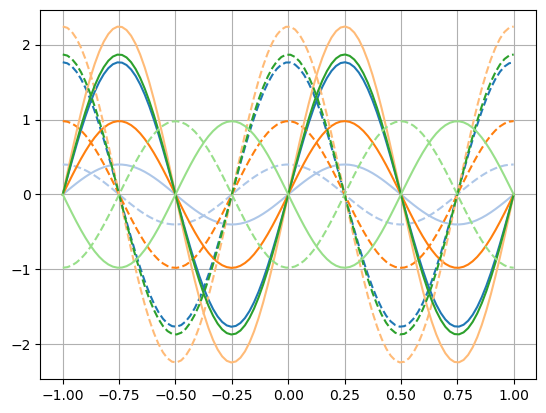

In [11]:
np.random.seed(0)
cmap = plt.get_cmap("tab20")

t = np.linspace(-1, 1, 100)
scale = np.random.normal(0.0, 1.0, (6, 1))
x = scale * np.sin(2 * np.pi * t)
y = scale * np.cos(2 * np.pi * t)
# Check
plt.figure()
for i, (x_, y_) in enumerate(zip(x, y)):
    plt.plot(t, x_, linestyle="-", color=cmap(i))
    plt.plot(t, y_, linestyle="--", color=cmap(i))
plt.grid()
plt.show()

In [12]:
timesteps = 10

train_x, train_y = make_dataset_for_stateful(x, y, timesteps)
print(train_y.shape)

(540, 1)


# モデルの取得

In [13]:
x_dim = 1
h_dim = 100
z_dim = 16

model = VRNN(input_shape=(timesteps, x_dim), h_dim=h_dim, z_dim=z_dim)

# 学習


In [14]:
loss = keras.losses.MeanSquaredError()
optimizer = keras.optimizers.Adam(learning_rate=0.001)

model.compile(optimizer=optimizer, loss=loss)

hist = model.fit(
    train_x, train_y,
    batch_size=len(x),
    epochs=10
)

Epoch 1/10
90/90 [==============================] - 7s 39ms/step - total_cost: 0.9023 - loss: 0.8511 - kl_divergence: 0.0512
Epoch 2/10
90/90 [==============================] - 3s 38ms/step - total_cost: 0.3110 - loss: 0.2978 - kl_divergence: 0.0132
Epoch 3/10
90/90 [==============================] - 3s 33ms/step - total_cost: 0.0614 - loss: 0.0590 - kl_divergence: 0.0023
Epoch 4/10
90/90 [==============================] - 3s 32ms/step - total_cost: 0.0479 - loss: 0.0468 - kl_divergence: 0.0011
Epoch 5/10
90/90 [==============================] - 3s 31ms/step - total_cost: 0.0259 - loss: 0.0254 - kl_divergence: 5.0341e-04
Epoch 6/10
90/90 [==============================] - 3s 30ms/step - total_cost: 0.0203 - loss: 0.0199 - kl_divergence: 3.9121e-04
Epoch 7/10
90/90 [==============================] - 3s 36ms/step - total_cost: 0.0217 - loss: 0.0214 - kl_divergence: 2.7172e-04
Epoch 8/10
90/90 [==============================] - 3s 36ms/step - total_cost: 0.0213 - loss: 0.0211 - kl_diverge

6


# 推論

In [248]:
t = np.linspace(-1, 1, 100)

x_ = np.sin(2 * np.pi * t).reshape(1, -1)
y_ = np.cos(2 * np.pi * t).reshape(1, -1)

test_x, _ = make_dataset_for_stateful(x_, y_, timesteps)

outputs = model(test_x)

pred_y = outputs[0]

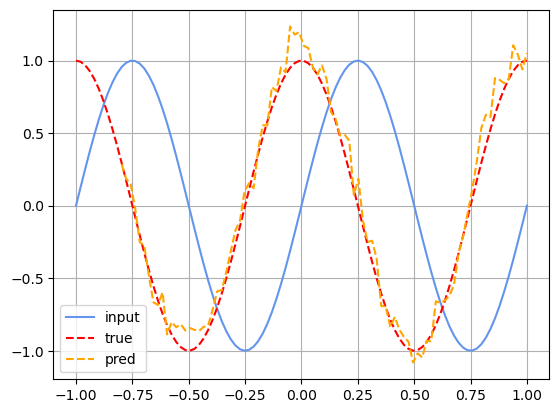

In [249]:
plt.figure()
plt.plot(t, np.squeeze(x_), linestyle="-", color="cornflowerblue", label="input")
plt.plot(t, np.squeeze(y_), linestyle="--", color="red", label="true")
plt.plot(t[timesteps:], np.squeeze(pred_y), linestyle="--", color="orange", label="pred")
plt.legend()
plt.grid()
plt.show()